## Packages #

In [111]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from collections import Counter
from pyds import MassFunction

In [112]:
gamma_q = 1
alpha_0 = 0.95
k = 9

In [113]:
n = 91
m = 71
x_p = np.linspace(0, 4.5, n)
y_p = np.linspace(1.5, 5, m)
X_p, Y_p = np.meshgrid(x_p, y_p)

In [114]:
data = loadmat('ex6data1.mat')
data_t = pd.read_csv('dataset_ex1.txt')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:28:43 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[1.9643  , 4.5957  ],
        [2.2753  , 3.8589  ],
        [2.9781  , 4.5651  ],
        [2.932   , 3.5519  ],
        [3.5772  , 2.856   ],
        [4.015   , 3.1937  ],
        [3.3814  , 3.4291  ],
        [3.9113  , 4.1761  ],
        [2.7822  , 4.0431  ],
        [2.5518  , 4.6162  ],
        [3.3698  , 3.9101  ],
        [3.1048  , 3.0709  ],
        [1.9182  , 4.0534  ],
        [2.2638  , 4.3706  ],
        [2.6555  , 3.5008  ],
        [3.1855  , 4.2888  ],
        [3.6579  , 3.8692  ],
        [3.9113  , 3.4291  ],
        [3.6002  , 3.1221  ],
        [3.0357  , 3.3165  ],
        [1.5841  , 3.3575  ],
        [2.0103  , 3.2039  ],
        [1.9527  , 2.7843  ],
        [2.2753  , 2.7127  ],
        [2.3099  , 2.9584  ],
        [2.8283  , 2.6309  ],
        [3.0473  , 2.2931  ],
        [2.4827  , 2.0373  ],
        [2.5057 

In [115]:
X = data['X']
y = data['y']
X_t = data_t[(['x1', 'x2'])]
num_train = X.shape[0]
num_test = data_t.shape[0]

In [116]:
def phi(d_s):
    return np.exp(- gamma_q * d_s)

In [117]:
def compute_distances(X_test, X_train):
    dists = np.zeros((num_test, num_train))
    M = np.dot(X_test, X_train.T)
    te = np.square(X_test).sum(axis=1)
    tr = np.square(X_train).sum(axis=1)
    dists = np.sqrt(-2 * M + np.matrix(tr) + np.matrix(te).T)
    return dists

In [118]:
def compute_bel(y_train, dists, k):
    bel1_pred = np.zeros(num_test)
    bel2_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        distances = np.sort(np.matrix(dists)).flatten()[:, 0:k]
        labels = np.matrix(y_train)[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0, 0:k]
        weights = np.zeros([2, k])
        count1 = 0
        count2 = 0
        for j in range(k):
            if closest_y.tolist()[0][j] == 1:
                count1 += 1
                weights[0][j] = distances.tolist()[0][j]
            else:
                count2 += 1
                weights[1][j] = distances.tolist()[0][j]
        m1 = [1, 0, 0]
        m2 = [0, 1, 0]
        for l in range(k):
            if weights[0][l] != 0:
                m1[0] *= 1 - alpha_0 * phi(weights[0][l])
            if weights[1][l] != 0:
                m2[1] *= 1 - alpha_0 * phi(weights[1][l])
        M1 = MassFunction({'1': 1 - m1[0], '2': 0, '12': m1[0]})
        M2 = MassFunction({'1': 0, '2': 1 - m2[1], '12': m2[1]})
        if count1 == 0:
            M = M2
        elif count2 == 0:
            M = M1
        else:
            M = M1 & M2
        bel1_pred[i] = round(M.bel({'1'}), 3)
        bel2_pred[i] = round(M.bel({'2'}), 3)
    return bel1_pred, bel2_pred

In [119]:
distances = compute_distances(X_t, X)
distances

matrix([[3.66631054, 3.27740741, 4.2736305 , ..., 1.76853934, 1.33224166,
         2.60593286],
        [3.63976689, 3.2428952 , 4.23893945, ..., 1.74349976, 1.30412915,
         2.60475442],
        [3.6137201 , 3.20879094, 4.20455677, ..., 1.71954977, 1.2773558 ,
         2.60453548],
        ...,
        [2.46902673, 2.41173367, 1.4869222 , ..., 4.01751309, 4.36044124,
         4.40556717],
        [2.51836514, 2.45589684, 1.5348054 , ..., 4.06109239, 4.40219636,
         4.45453494],
        [2.56772915, 2.50027984, 1.58281952, ..., 4.10481807, 4.44412172,
         4.50352541]])

In [120]:
bel1, bel2 = compute_bel(y, distances, k)

In [121]:
bel1

array([0.   , 0.   , 0.   , ..., 0.836, 0.836, 0.836])

In [122]:
bel2

array([0.836, 0.836, 0.836, ..., 0.   , 0.   , 0.   ])

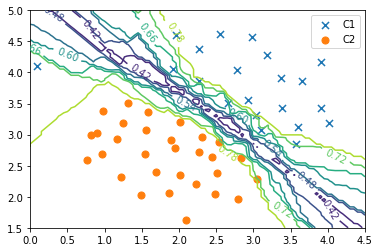

In [123]:
bel = np.zeros(num_test)
for i in range(num_test):
    bel[i] = max(bel1[i], bel2[i])

bel = np.reshape(bel, (m, n))

raw_data = loadmat('ex6data1.mat')

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

plt.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='C1')
plt.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='C2')
plt.legend()
C = plt.contour(X_p, Y_p, bel)
plt.clabel(C, inline=True, fontsize=10)

plt.show()